# 1. Imports

In [2]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor

from data_processing import get_clustered_data_with_bus_only, get_numeric_name, split_into_lines, get_train_and_test_by_lines

# 2. Settings

In [3]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [4]:
def read_transport_data(filename):
    types_mapping = {
        'Numer / oznaczenie linii' : str,
        'Wariant linii' : str,
        'Kurs' : str,
        'Oznaczenie brygady' : str,
        'Czas rzeczywisty odjazdu wg. rozkładu' : str,
        'Czas odjazdu z przystanku' : str,
    }

    df = pd.read_csv(filename, sep=';', dtype=types_mapping)
    df = df.drop(columns='Data')

    names_mapping = {
        'Numer / oznaczenie linii' : 'Nr linii',
        # 'Wariant linii'
        # 'Kurs'
        # 'Oznaczenie brygady'
        # 'Numer taborowy'
        # 'Nazwa przystanku'
        # 'Numer przystanku'
        'Czas rzeczywisty odjazdu wg. rozkładu' : 'Rzeczywisty czas odjazdu',
        'Czas odjazdu z przystanku' : 'Rozkładowy czas odjazdu',
        'Liczba pasażerów w pojeździe przed przystankiem (dane skorygowane)' : 'Liczba pasaz. przed',
        'Liczba osób które wysiadły (dane skorygowane)' : 'Liczba wysiadających pasaz.',
        'Liczba osób które wsiadły (dane skorygowane)' : 'Liczba wsiadajacych pasaz.',
        'Liczba pasażerów w pojeździe po odjeździe (dane skorygowane)' : 'Liczba pasaz. po odjezdzie'
    }
    df.rename(columns=names_mapping, inplace=True)

    return df

In [5]:
df = read_transport_data('./data/SZP-2021-09-03.csv')

# 4. Inspecting Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177546 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     177546 non-null  object
 1   Wariant linii                177546 non-null  object
 2   Kurs                         177546 non-null  object
 3   Oznaczenie brygady           177546 non-null  object
 4   Numer taborowy               177546 non-null  int64 
 5   Nazwa przystanku             177546 non-null  object
 6   Numer przystanku             177546 non-null  int64 
 7   Rzeczywisty czas odjazdu     172273 non-null  object
 8   Rozkładowy czas odjazdu      177546 non-null  object
 9   Liczba pasaz. przed          177546 non-null  int64 
 10  Liczba wysiadających pasaz.  177546 non-null  int64 
 11  Liczba wsiadajacych pasaz.   177546 non-null  int64 
 12  Liczba pasaz. po odjezdzie   177546 non-null  int64 
dtypes: int64(6), o

In [7]:
df.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
140316,525,TP-DWC,05:44,3,9817,IX Poprzeczna,2,05:50:00,05:51,6,0,0,6
7499,106,TP-MLY,16:10,2,9513,pl.Grzybowski,4,16:24:00,16:25,10,0,0,10
159273,739,TO-WIL,14:10,3,9352,Energetyczna,2,14:25:00,14:26,23,1,5,27
8749,118,TP-MPL,15:35,1,9679,Metro Politechnika,9,16:17:00,16:23:53,13,0,0,13
62746,179,TP-MKA,14:55,4,9325,os.Kabaty,2,15:39:00,15:49,7,7,0,0


In [8]:
df.describe()

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
count,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000
mean,9513.375953,3.437903,12.060711,1.560435,1.570534,12.070810
std,265.044802,7.857952,12.341741,3.136487,3.192504,12.335713
min,9061.000000,1.000000,-3.000000,0.000000,0.000000,0.000000
25%,9319.000000,1.000000,4.000000,0.000000,0.000000,4.000000
50%,9452.000000,2.000000,9.000000,0.000000,0.000000,9.000000
75%,9806.000000,3.000000,16.000000,2.000000,2.000000,16.000000
max,9955.000000,88.000000,133.000000,124.000000,110.000000,133.000000


# 4.1. Check data

In [9]:
counter = 0
counter += len(df.loc[df['Liczba pasaz. przed'] - df['Liczba wysiadających pasaz.'] + df['Liczba wsiadajacych pasaz.'] != df['Liczba pasaz. po odjezdzie']])
counter += len(df[df['Liczba pasaz. przed'] < 0])
print(f'Amount of invalid data: {counter}')

Amount of invalid data: 2


# 4.2. Remove errors

In [10]:
df.drop(df[df['Liczba pasaz. przed'] < 0].index, inplace=True) # remove invlid amout of passengers

df.drop(df[df['Kurs'].str[:2] > '23'].index, inplace= True)

is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

df.drop(df[row_has_NaN].index, inplace=True)


# 4.3. Parse data

In [11]:
def make_date_one_type(x):
    return pd.Timestamp(x)

In [12]:
df['Kurs'] = df['Kurs'].apply(lambda x: make_date_one_type(x))
df['Rzeczywisty czas odjazdu'] = df['Rzeczywisty czas odjazdu'].apply(lambda x: make_date_one_type(x))
df['Rozkładowy czas odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: make_date_one_type(x))

In [13]:
df['Godzina odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)
df['Godzina odjazdu przedział'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour * 4 + floor(x.minute/15))

# 4.4. New data

In [14]:
trans_type = []
for nr in df['Nr linii']:
    if nr.isnumeric():
        trans_type.append('autobus')
    elif nr[0] == 'N':
        trans_type.append('nocny')
    elif nr[0] == 'Z':
        trans_type.append('zastepczy')
    else:
        trans_type.append('inny')
df['Typ'] = trans_type

In [15]:
df['Opóźnienie w minutach'] = (df['Rzeczywisty czas odjazdu'] - df['Rozkładowy czas odjazdu']).apply(lambda x: int(x.total_seconds()//60))

## 4.5 Clustering

In [16]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)

    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))

    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)

    return df


In [17]:
crowding = ['niezatłoczony','zatłoczony']
iterations = 10

df = find_clusters(crowding, iterations, df, 'Liczba pasaz. po odjezdzie')

<Figure size 720x576 with 0 Axes>

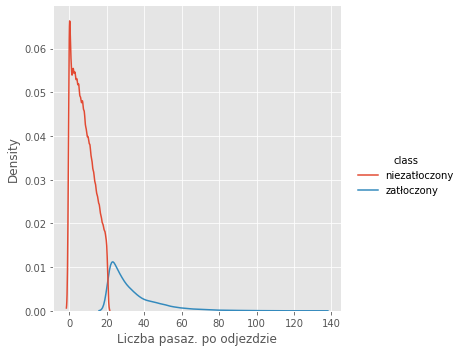

In [18]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='Liczba pasaz. po odjezdzie',
    hue='class',
    kind='kde'
)

# 5. Binary classification using XGBoost

<https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390>

In [19]:
df.head()

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,Typ,Opóźnienie w minutach,class
0,102,TP-EMP,2022-01-30 05:11:00,1,9415,PKP Olszynka Grochowska,4,2022-01-30 05:11:00,2022-01-30 05:11:00,0,0,1,1,5.183333,20,autobus,0,niezatłoczony
1,102,TP-EMP,2022-01-30 05:11:00,1,9415,Chłopickiego,3,2022-01-30 05:12:00,2022-01-30 05:11:00,1,0,0,1,5.183333,20,autobus,1,niezatłoczony
2,102,TP-EMP,2022-01-30 05:11:00,1,9415,Osiedle Młodych,1,2022-01-30 05:13:00,2022-01-30 05:12:00,1,0,2,3,5.200000,20,autobus,1,niezatłoczony
3,102,TP-EMP,2022-01-30 05:11:00,1,9415,Garwolińska,1,2022-01-30 05:14:00,2022-01-30 05:13:00,3,0,0,3,5.216667,20,autobus,1,niezatłoczony
4,102,TP-EMP,2022-01-30 05:11:00,1,9415,Szaserów-Szpital,1,2022-01-30 05:15:00,2022-01-30 05:14:00,3,0,0,3,5.233333,20,autobus,1,niezatłoczony


In [20]:
features = ['Nr linii', 'Nazwa przystanku', 'Godzina odjazdu', 'Opóźnienie w minutach']

In [21]:
X = df[features]
y = df[['class']]

In [22]:
X.head()

,Nr linii,Nazwa przystanku,Godzina odjazdu,Opóźnienie w minutach
0,102,PKP Olszynka Grochowska,5.183333,0
1,102,Chłopickiego,5.183333,1
2,102,Osiedle Młodych,5.200000,1
3,102,Garwolińska,5.216667,1
4,102,Szaserów-Szpital,5.233333,1


In [23]:
y.head()

,class
0,niezatłoczony
1,niezatłoczony
2,niezatłoczony
3,niezatłoczony
4,niezatłoczony


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [25]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

In [26]:
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")),
           ("scale", StandardScaler())]
)

In [27]:
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [28]:
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [32]:
xgb_cl = xgb.XGBClassifier(seed = RANDOM_SEED)
X_train, X_test, y_train, y_test = get_train_and_test_by_lines(df, features, ['class'])
X_train = full_processor.fit_transform(X_train)
X_test = full_processor.fit_transform(X_test)
y_train = SimpleImputer(strategy="most_frequent").fit_transform(
    y_train.values.reshape(-1, 1)
)
y_test = SimpleImputer(strategy="most_frequent").fit_transform(
    y_test.values.reshape(-1, 1)
)

# concated = pd.DataFrame(np.concatenate((X_processed, y_processed), axis=1), columns=features+['class'])

# X_train, X_test, y_train, y_test = get_train_and_test_by_lines(pd.concat([X, y], axis=1), features, ['class'])

In [33]:
# Fit
xgb_cl.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[13:05:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [34]:

# Predict
preds = xgb_cl.predict(X_test)

In [35]:
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True,
                cbar=False,
                xticklabels=xticks,
                yticklabels=yticks,
                ax=ax)

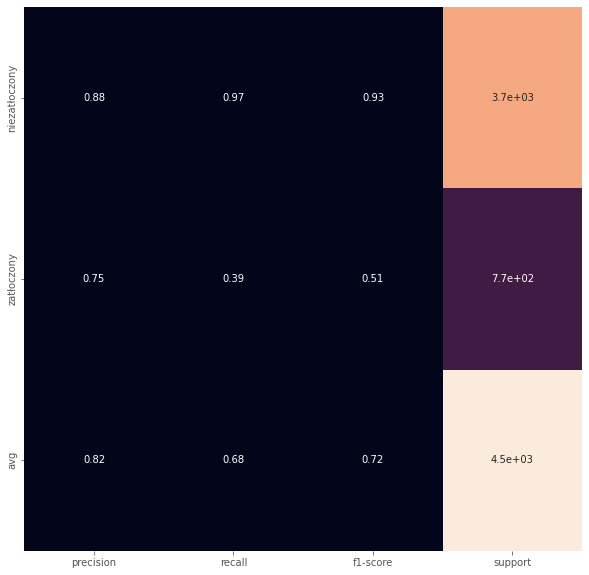

In [36]:

# Score
plot_classification_report(y_test, preds)

# 6. Regression using XGBoost

In [37]:
y = df['Liczba pasaz. po odjezdzie']

In [38]:
y.head()

0    1
1    1
2    3
3    3
4    3
Name: Liczba pasaz. po odjezdzie, dtype: int64

In [40]:
xgb_rg = xgb.XGBRegressor(seed = RANDOM_SEED)
X_train, X_test, y_train, y_test = get_train_and_test_by_lines(df, features, ['Liczba pasaz. po odjezdzie'])
X_train = full_processor.fit_transform(X_train)
X_test = full_processor.fit_transform(X_test)
y_train = SimpleImputer(strategy="mean").fit_transform(
    y_train.values.reshape(-1, 1)
)
y_test = SimpleImputer(strategy="mean").fit_transform(
    y_test.values.reshape(-1, 1)
)

In [41]:
# Fitting the model
xgb_rg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
# Predict the model
pred = xgb_rg.predict(X_test)

In [62]:
# Errors Computation
absolute_errors = pd.DataFrame(abs(y_test - pred.reshape(-1, 1)))
stats = absolute_errors.describe().round(2)
stats

,0
count,4496.00
mean,5.75
std,6.39
min,0.00
25%,1.84
50%,4.07
75%,7.33
max,60.64
